# Uncertainty Evaluation (Resnet18 from scratch on SVHN)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import wandb
from tqdm.autonotebook import trange

!wandb login

/tmp/ipykernel_94002/835565520.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


wandb: Currently logged in as: wei2912. Use `wandb login --relogin` to force relogin


In [2]:
run = wandb.init(
    project="i2r-active-da",
    job_type="train",
    config={
        # parameters roughly similar to LIRR
        "optim": {
            "algorithm": "AdamW",
            "lr": 1e-3,
            "weight_decay": 5e-4,
        },
        "batch_size": 64,
        "num_epochs": 20,
        "num_workers": 4,
        "cuda_device": 0,
    },
)
config = run.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wei2912. Use `wandb login --relogin` to force relogin


## SVHN Dataset

In [3]:
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor

train_data_svhn = SVHN('data/svhn', download=True, split='train', transform=ToTensor())
train_loader_svhn = torch.utils.data.DataLoader(train_data_svhn,
                                          batch_size=config.batch_size,
                                          shuffle=True,
                                          num_workers=config.num_workers,
                                          pin_memory=True)

test_data_svhn = SVHN('data/svhn', download=True, split='test', transform=ToTensor())
test_loader_svhn = torch.utils.data.DataLoader(test_data_svhn,
                                          batch_size=config.batch_size,
                                          num_workers=config.num_workers,
                                          pin_memory=True)

Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


Label: 0


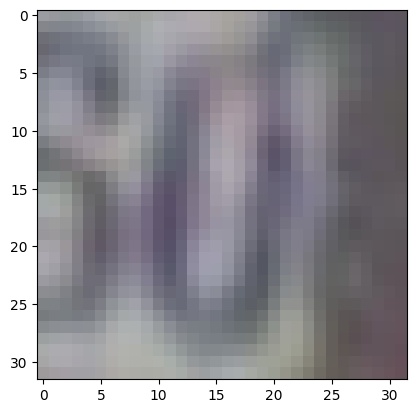

In [4]:
inputs, targets = next(iter(train_loader_svhn))
plt.imshow(torch.einsum('cwh->whc', inputs[0]))
print(f"Label: {targets[0]}")

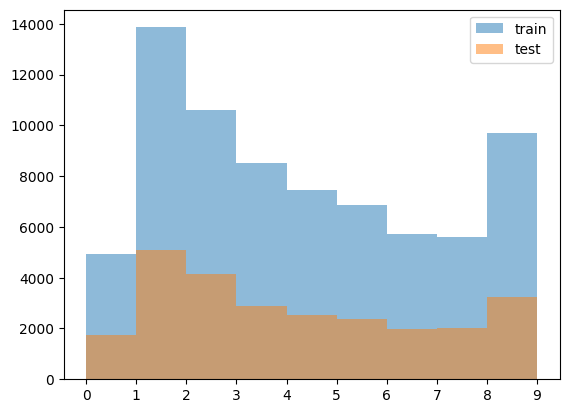

In [5]:
train_targets = []
for _, targets in list(train_loader_svhn):
    train_targets.extend(targets.tolist())

test_targets = []
for _, targets in list(test_loader_svhn):
    test_targets.extend(targets.tolist())

bins = range(10)
plt.xticks(bins)
plt.hist(train_targets, bins, alpha=0.5, label='train')
plt.hist(test_targets, bins, alpha=0.5, label='test')
plt.legend()
plt.show()

## Training Setup

In [6]:
torch.cuda.set_device(config.cuda_device)
device = torch.device(f"cuda:{config.cuda_device}" if torch.cuda.is_available() else "cpu")

In [7]:
from torch.nn import Linear
from torchinfo import summary
from torchvision.models import resnet18

model = resnet18(weights=None).to(device)
model.fc = Linear(in_features=model.fc.in_features, out_features=10, bias=True)

summary(model, input_size=(config.batch_size, 3, 32, 32), depth=1)

/home/wei2912/Workspace/wei2912/i2r-active-da/.venv/lib64/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 16, 16]          128
├─ReLU: 1-3                              [64, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 64, 8, 8]            --
├─Sequential: 1-5                        [64, 64, 8, 8]            147,968
├─Sequential: 1-6                        [64, 128, 4, 4]           525,568
├─Sequential: 1-7                        [64, 256, 2, 2]           2,099,712
├─Sequential: 1-8                        [64, 512, 1, 1]           8,393,728
├─AdaptiveAvgPool2d: 1-9                 [64, 512, 1, 1]           --
├─Linear: 1-10                           [64, 10]                  5,130
Total params: 11,181,642
Trainable params: 11,181,642
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.37
Input 

In [8]:
from pathlib import Path

def save_model():
    path = Path(f"results/{run.id}/")
    path.mkdir(parents=True, exist_ok=True)

    model_name = f"resnet18-svhn-{epoch:03}"
    torch.save(model, path / f"{model_name}.pt")

    artifact_model = wandb.Artifact(model_name, type="model")
    artifact_model.add_file(path / f"{model_name}.pt")
    wandb.log_artifact(artifact_model, aliases=["latest"])

In [9]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

criterion = CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=config.optim["lr"], weight_decay=config.optim["weight_decay"])

In [10]:
from sklearn.metrics import top_k_accuracy_score
import time

def train_epoch():
    model.train()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for (input, target) in train_loader_svhn:
        if device is not None:
            input = input.to(device)
            target = target.to(device)
        
        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.squeeze().tolist())
        targets.extend(target.tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end = time.monotonic()

    save_model()
    return {
        "train_time": end - start,
        "train_loss": sum(losses) / len(losses),
        "train_top1": top_k_accuracy_score(
            targets, outputs, k=1, labels=range(10)
        ),
    }

### Uncertainty Metrics

In [11]:
def test_epoch():
    model.eval()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for (input, target) in test_loader_svhn:
        if device is not None:
            input = input.to(device)
            target = target.to(device)
        
        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.squeeze().tolist())
        targets.extend(target.tolist())

    end = time.monotonic()

    return (outputs, targets, {
        "test_time": end - start,
        "test_loss": sum(losses) / len(losses),
        "test_top1": top_k_accuracy_score(
            targets, outputs, k=1, labels=range(10)
        ),
    })

### Experiment Results

In [12]:
def softmax(outputs):
    return np.exp(outputs) / np.sum(np.exp(outputs), axis=0)

def predictive_entropy(pss):
    return (-pss * np.log(pss)).sum(axis=1)

def margin(pss):
    inds = np.argsort(pss, axis=1)
    max2s = np.take_along_axis(pss, inds[:, -2:], axis=1)
    return max2s[:, 1] - max2s[:, 0]

In [13]:
df_uncertainty = pd.DataFrame(columns=["targets", "outputs", "probs", "is_correct", "predictive_entropy", "margin"])

for epoch in trange(config.num_epochs):
    metrics = train_epoch()
    outputs, targets, test_metrics = test_epoch()
    metrics.update(test_metrics)
    wandb.log(metrics)

    targets, outputs = np.array(targets), np.array(outputs)
    pss = softmax(outputs)
    cs = np.argmax(pss, axis=1) == targets
    pes = predictive_entropy(pss)
    ms = margin(pss)
    
    df_uncertainty.loc[epoch] = [
        targets,
        outputs,
        pss,
        cs,
        pes,
        ms
    ]

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
df_uncertainty

,targets,outputs,probs,is_correct,predictive_entropy,margin
0,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-3.543923854827881, -0.45453914999961853, -0...","[[9.404125799755083e-09, 4.3378152133630074e-0...","[True, True, True, True, False, True, True, Tr...","[0.00017986702898236892, 0.0001389859808288396...","[1.0037750911803941e-05, 6.87591938088275e-06,..."
1,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.146800518035889, -0.6198291182518005, -1....","[[7.474430426042487e-10, 4.1447597772323104e-0...","[True, True, True, True, True, True, True, Tru...","[0.0003825732176435941, 0.0012852929282582972,...","[3.316555077169284e-05, 0.00014096119256694069..."
2,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-3.503994941711426, -2.3039755821228027, -2....","[[1.1461712776074606e-08, 1.503643371840761e-0...","[True, True, True, True, True, True, True, Tru...","[0.0003072007248302627, 0.0005275916875475123,...","[2.6633378128223866e-05, 5.003233471371983e-05..."
3,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-5.5915632247924805, -1.1299418210983276, -1...","[[6.791946623825668e-10, 2.834524300069358e-07...","[True, True, True, True, True, True, True, Tru...","[0.00035930687339989255, 0.0004218424307631708...","[3.333703674416779e-05, 4.016589317603946e-05,..."
4,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.95134973526001, -2.748457908630371, -0.84...","[[1.0568580635358678e-08, 4.346892053853082e-0...","[True, True, True, True, False, True, True, Tr...","[0.0018192621958989625, 0.00018017172377741994...","[0.00021445692051861787, 1.5135372735145422e-0..."
5,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.481992721557617, -2.8898134231567383, -1....","[[3.7005736533808324e-09, 1.352617704183165e-0...","[True, True, True, True, True, True, True, Tru...","[0.0009460430618739448, 0.001142811452904782, ...","[0.00010177539957919668, 0.0001265686171681941..."
6,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-5.5390424728393555, -1.3799545764923096, -1...","[[2.4005692067834777e-09, 8.380419527033244e-0...","[True, True, True, True, True, True, True, Tru...","[0.0017689904311136277, 0.003385049130284836, ...","[0.00020807384985158036, 0.0004374577890140746..."
7,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.956610202789307, -2.6430556774139404, -2....","[[1.095797769813982e-09, 5.7384291639354514e-0...","[True, True, True, True, False, True, True, Tr...","[0.0004986661423545318, 0.001964813071541402, ...","[4.990312739187369e-05, 0.00023451051077749135..."
8,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-6.316867828369141, -3.990586042404175, -1.9...","[[1.3605792899036433e-10, 9.250641089276284e-0...","[True, True, True, True, True, True, True, Tru...","[0.000942341635302759, 0.0002280450387455709, ...","[0.00010031245014488896, 2.056357285279248e-05..."
9,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-6.629204750061035, -4.296842098236084, -2.3...","[[2.1519425656634118e-10, 2.653495779572471e-1...","[True, True, True, True, True, True, True, Tru...","[0.0006487579580244343, 0.0008005009600582252,...","[6.679442874651894e-05, 8.529139061578456e-05,..."


In [24]:
path = Path(f"results/{run.id}/")
path.mkdir(parents=True, exist_ok=True)
df_uncertainty.to_pickle(path / "uncertainty.pickle")

In [31]:
artifact_df_uncertainty = wandb.Artifact("uncertainty_dataframe", type="dataframe")
artifact_model.add_file(path / f"uncertainty.pickle")
wandb.log_artifact(artifact_df_uncertainty)

In [32]:
run.finish()

## Analysis

In [5]:
run = wandb.init(
    project="i2r-active-da",
    job_type="analysis",
    config={ "run_id": run.id }
)
config = run.config

In [9]:
from pathlib import Path

path = Path(f"results/{config.run_id}/")
df_uncertainty = pd.read_pickle(path / "uncertainty.pickle")

In [10]:
df_uncertainty

,targets,outputs,probs,is_correct,predictive_entropy,margin
0,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-3.543923854827881, -0.45453914999961853, -0...","[[9.404125799755083e-09, 4.3378152133630074e-0...","[True, True, True, True, False, True, True, Tr...","[0.00017986702898236892, 0.0001389859808288396...","[1.0037750911803941e-05, 6.87591938088275e-06,..."
1,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.146800518035889, -0.6198291182518005, -1....","[[7.474430426042487e-10, 4.1447597772323104e-0...","[True, True, True, True, True, True, True, Tru...","[0.0003825732176435941, 0.0012852929282582972,...","[3.316555077169284e-05, 0.00014096119256694069..."
2,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-3.503994941711426, -2.3039755821228027, -2....","[[1.1461712776074606e-08, 1.503643371840761e-0...","[True, True, True, True, True, True, True, Tru...","[0.0003072007248302627, 0.0005275916875475123,...","[2.6633378128223866e-05, 5.003233471371983e-05..."
3,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-5.5915632247924805, -1.1299418210983276, -1...","[[6.791946623825668e-10, 2.834524300069358e-07...","[True, True, True, True, True, True, True, Tru...","[0.00035930687339989255, 0.0004218424307631708...","[3.333703674416779e-05, 4.016589317603946e-05,..."
4,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.95134973526001, -2.748457908630371, -0.84...","[[1.0568580635358678e-08, 4.346892053853082e-0...","[True, True, True, True, False, True, True, Tr...","[0.0018192621958989625, 0.00018017172377741994...","[0.00021445692051861787, 1.5135372735145422e-0..."
5,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.481992721557617, -2.8898134231567383, -1....","[[3.7005736533808324e-09, 1.352617704183165e-0...","[True, True, True, True, True, True, True, Tru...","[0.0009460430618739448, 0.001142811452904782, ...","[0.00010177539957919668, 0.0001265686171681941..."
6,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-5.5390424728393555, -1.3799545764923096, -1...","[[2.4005692067834777e-09, 8.380419527033244e-0...","[True, True, True, True, True, True, True, Tru...","[0.0017689904311136277, 0.003385049130284836, ...","[0.00020807384985158036, 0.0004374577890140746..."
7,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-4.956610202789307, -2.6430556774139404, -2....","[[1.095797769813982e-09, 5.7384291639354514e-0...","[True, True, True, True, False, True, True, Tr...","[0.0004986661423545318, 0.001964813071541402, ...","[4.990312739187369e-05, 0.00023451051077749135..."
8,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-6.316867828369141, -3.990586042404175, -1.9...","[[1.3605792899036433e-10, 9.250641089276284e-0...","[True, True, True, True, True, True, True, Tru...","[0.000942341635302759, 0.0002280450387455709, ...","[0.00010031245014488896, 2.056357285279248e-05..."
9,"[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, ...","[[-6.629204750061035, -4.296842098236084, -2.3...","[[2.1519425656634118e-10, 2.653495779572471e-1...","[True, True, True, True, True, True, True, Tru...","[0.0006487579580244343, 0.0008005009600582252,...","[6.679442874651894e-05, 8.529139061578456e-05,..."


In [22]:
for epoch in trange(len(df_uncertainty)):
    row = df_uncertainty.iloc[epoch]
    targets, _, _, cs, pes, ms = row
    data = np.array([targets, cs, pes, ms]).T
    table_epoch = wandb.Table(columns=["target", "is_correct", "predictive_entropy", "margin"], data=data)
    run.log({f"{epoch}": table_epoch})

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
run.finish()